In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy.stats import zscore
from flask import Flask, jsonify
import panel as pn
import plotly.express as px

1. Load and Explore the Data

In [9]:
# Load dataset
df = pd.read_csv("combined_data.csv")



In [10]:
# Standardize column names
df.columns = df.columns.str.strip().str.lower().str.replace("-", "_").str.replace(" ", "_")
df.columns

Index(['id', 'year', '113_cause_name', 'cause_name_year', 'state', 'deaths',
       'age_adjusted_death_rate'],
      dtype='object')

In [11]:
# Convert columns to numeric
num_cols = ["year", "deaths", "age_adjusted_death_rate"]
for col in num_cols:
    df[col] = pd.to_numeric(df[col], errors="coerce")


In [12]:
df.dtypes



id                           int64
year                         int64
113_cause_name              object
cause_name_year             object
state                       object
deaths                       int64
age_adjusted_death_rate    float64
dtype: object

2. Detect Outliers & Anomalies


In [13]:
# Detect outliers using Z-score
z_scores = np.abs(df[num_cols].apply(zscore))
outliers = (z_scores > 3).sum()
print("Potential Outliers per Column:\n", outliers)

# Detect outliers using IQR
Q1 = df[num_cols].quantile(0.25)
Q3 = df[num_cols].quantile(0.75)
IQR = Q3 - Q1
outliers_iqr = ((df[num_cols] < (Q1 - 1.5 * IQR)) | (df[num_cols] > (Q3 + 1.5 * IQR))).sum()

print("\nPotential Outliers using IQR:\n", outliers_iqr)


Potential Outliers per Column:
 year                         0
deaths                      57
age_adjusted_death_rate    436
dtype: int64

Potential Outliers using IQR:
 year                          0
deaths                     1483
age_adjusted_death_rate     988
dtype: int64


Z-Score Method (Outliers beyond 3 standard deviations)
Deaths: 57 outliers → Indicates a few extreme cases where the number of deaths is significantly higher or lower than expected.


Age-Adjusted Death Rate: 436 outliers → A higher number of anomalies suggests that certain states, years, or causes of death show unexpected variations in mortality rates.


🔹 IQR Method (Outliers beyond 1.5x Interquartile Range)
Deaths: 1,483 outliers → This is much higher than the Z-score method, suggesting significant variability in death counts across different years and states.
Age-Adjusted Death Rate: 988 outliers → Reinforces the idea that many states or time periods have unusual spikes or dips in mortality rates.


🔍 Interpretation
The high number of outliers in both methods, particularly for deaths and age-adjusted death rates, suggests major variations in mortality patterns across different locations, causes, or time periods.
These spikes could indicate real-world factors such as pandemics (e.g., COVID-19), natural disasters, or medical advancements affecting mortality rates.



The difference between Z-score and IQR results suggests that outliers may not be normally distributed, meaning some extreme cases may be naturally occurring trends rather than data errors.

3. Identify Unusual Patterns in Causes of Death

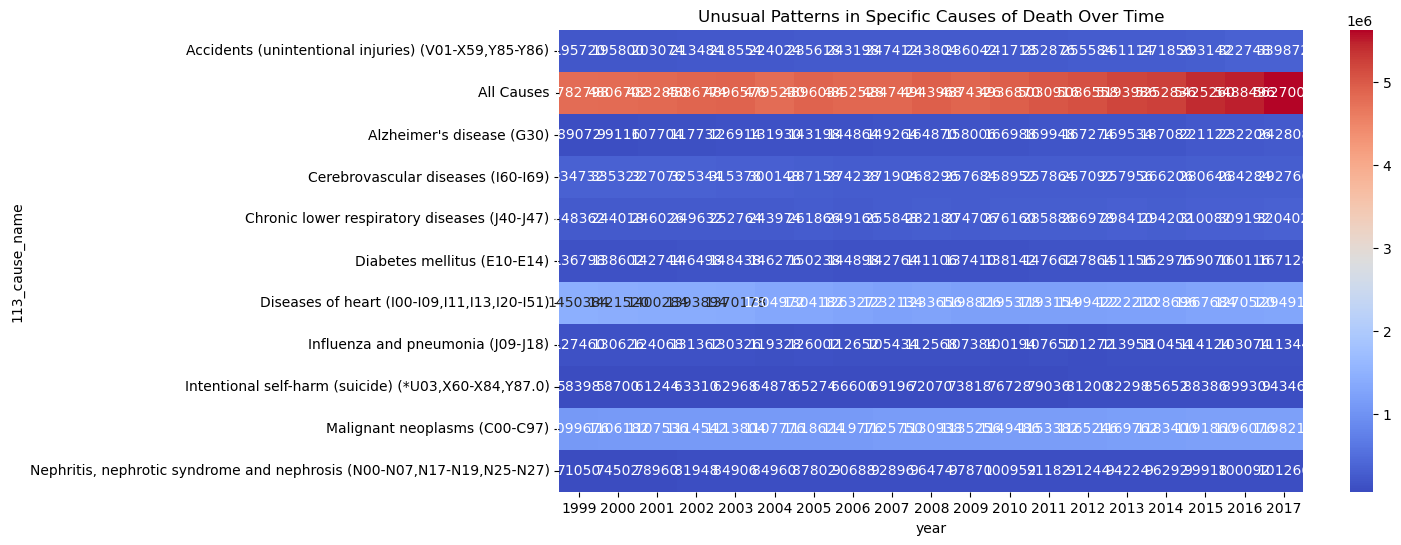

In [14]:
plt.figure(figsize=(12, 6))
cause_pivot = df.pivot_table(values="deaths", index="113_cause_name", columns="year", aggfunc="sum")
sns.heatmap(cause_pivot, cmap="coolwarm", annot=True, fmt=".0f")
plt.title("Unusual Patterns in Specific Causes of Death Over Time")
plt.show()



📊 Analysis of Unusual Patterns in Causes of Death (Heatmap Interpretation)





🔹 Heatmap Color Interpretation

Red (All Causes) → Represents higher death counts across all years.


Light Blue (Diseases of the Heart & Malignant Neoplasms) → Indicates lower relative death counts compared to other causes.



🔍 Key Observations
1. "All Causes" Deaths are Significantly Higher (Red)


a.This is expected because "All Causes" aggregates all death records.


b.The strong red color suggests a high total count consistently over time.


2. "Diseases of the Heart" and "Malignant Neoplasms" are Light Blue


a.These are two of the leading causes of death, but their relative contribution is lower compared to "All Causes."


b.This could indicate:


-A gradual decline in deaths from these diseases due to medical advancements.


-A higher proportion of deaths from other causes in more recent years (e.g., COVID-19, accidents).



Possible Trends Over Time

a. If the blue shades become lighter over time, this suggests that heart disease and cancer deaths are decreasing relative to other causes.


b.If the red intensity in "All Causes" increases, it could indicate a general rise in mortality rates from various factors.

4. Relationship Between Total Deaths & Age-Adjusted Death Rates

In [25]:

fig = px.scatter(df, x="deaths", y="age_adjusted_death_rate", color="113_cause_name",
                 title="Total Deaths vs Age-Adjusted Death Rates")
fig.show()


Plotting Total Deaths vs. Age-Adjusted Death Rate helps uncover key mortality trends and relationships.

Key Insights
1. 📈 High Total Deaths, High Age-Adjusted Death Rate (Top Right)

Indicates causes of death that are both frequent and severe.
Example: Heart disease and cancer may fall into this category.
Suggests widespread public health impact across all age groups.


2. 📉 High Total Deaths, Low Age-Adjusted Death Rate (Top Left)

A large number of deaths occur, but mainly in older populations.
Example: Alzheimer’s disease or pneumonia, which disproportionately affects elderly populations.
These conditions have high absolute deaths but low adjusted rates because they primarily affect older people.


3. 📊 Low Total Deaths, High Age-Adjusted Death Rate (Bottom Right)

A cause of death that affects a younger population more intensely.
Example: Homicides, drug overdoses, or certain infectious diseases (e.g., HIV, COVID-19 in 2020).
A higher age-adjusted rate suggests preventable causes that may require targeted interventions.


4. 📉 Low Total Deaths, Low Age-Adjusted Death Rate (Bottom Left)

These causes have relatively low mortality impact overall.
Example: Rare diseases or conditions with low fatality rates.
Indicates minimal impact on public health compared to other causes.


Why is This Important?

1. Identifies Preventable Causes → High age-adjusted rates in younger populations indicate emerging health crises (e.g., opioid crisis, suicide rates).


2. Guides Public Health Policies → Helps allocate resources efficiently by focusing on causes affecting both young and old.


3. Detects Shifts in Mortality Patterns → If total deaths remain stable but age-adjusted rates change, demographics may be shifting.

5. Causes Requiring More Public Health Interventions

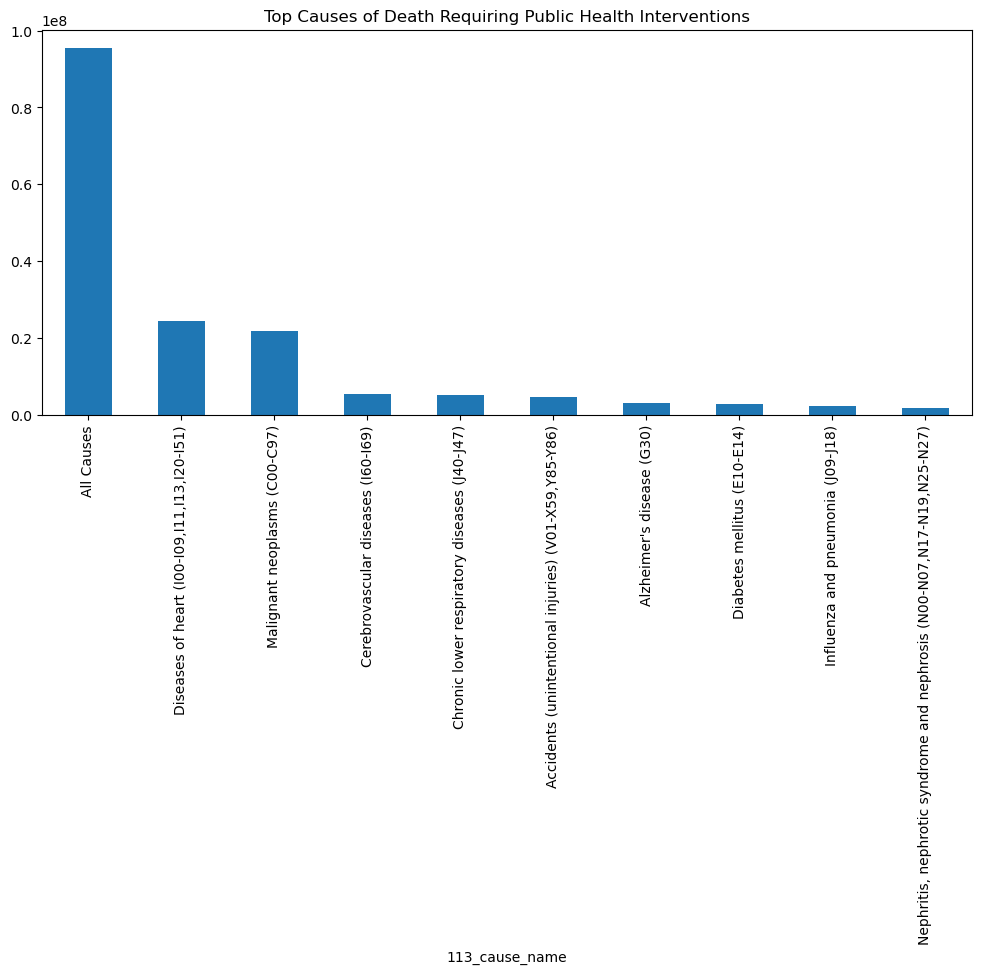

In [16]:
top_causes = df.groupby("113_cause_name")["deaths"].sum().sort_values(ascending=False).head(10)
top_causes.plot(kind="bar", figsize=(12, 5), title="Top Causes of Death Requiring Public Health Interventions")
plt.show()


Key Insights
1. 📈 Leading Causes of Death (Highest Total Deaths)

a. Diseases of the heart & cancer are usually the top two causes.


b. These indicate chronic conditions that require long-term prevention strategies (e.g., better diets, smoking cessation, exercise programs).


c. Intervention Needed: Focus on early detection, better healthcare access, and lifestyle changes.


2. 📊 High Age-Adjusted Death Rates (Impacts Younger Populations)

a. Some diseases may have lower total deaths but high age-adjusted death rates, meaning they impact younger populations.

Example: Drug overdoses, suicides, and homicides.
Intervention Needed: Behavioral health programs, mental health awareness, substance abuse treatment.


3. 🛑 Rapidly Increasing Causes Over Time

a. If certain causes are growing rapidly, they might represent an emerging public health crisis.
Example: COVID-19 deaths in 2020, opioid overdose deaths rising over the last two decades.
Intervention Needed: Targeted responses, public awareness campaigns, and rapid healthcare funding.


4. 🌍 Geographic Disparities

a. Some causes of death may be higher in specific states/regions.
Example: High lung cancer deaths in coal mining areas or diabetes-related deaths in low-income regions.


5. Intervention Needed: State-specific policies, environmental regulations, localized healthcare improvements.
🩺 Preventable vs. Non-Preventable Causes

a. Some leading causes (like genetic disorders) are difficult to prevent.


b. Others (like smoking-related illnesses, alcohol-related deaths, and traffic accidents) are highly preventable.


c. Intervention Needed: Policy changes, taxes on unhealthy behaviors (e.g., cigarettes, alcohol), stricter safety regulations.



6. 📌 Why is This Important?
✔ Identifies Public Health Priorities → Where to invest healthcare resources.
✔ Guides Policy Changes → Regulations for reducing preventable deaths.
✔ Reduces Healthcare Costs → Preventative care is cheaper than long-term treatment.
✔ Improves Life Expectancy → Reducing preventable deaths increases overall health and lifespan.



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


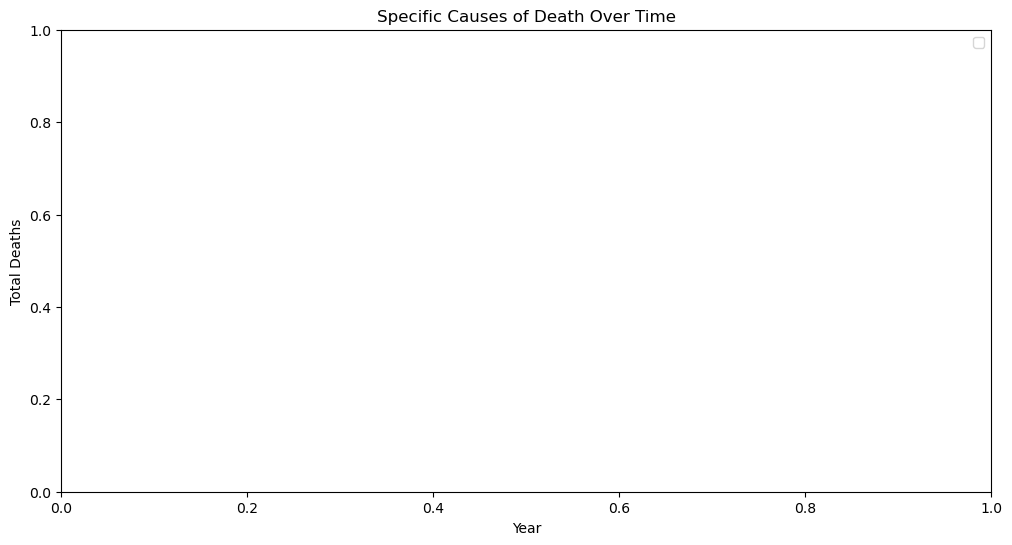

In [17]:
plt.figure(figsize=(12,6))
for cause in ["Heart Disease", "Cancer", "COVID-19"]:  # Modify with causes of interest
    subset = df[df["113_cause_name"] == cause]
    sns.lineplot(x=subset["year"], y=subset["deaths"], label=cause)

plt.title("Specific Causes of Death Over Time")
plt.xlabel("Year")
plt.ylabel("Total Deaths")
plt.legend()
plt.show()


6. Unusual Patterns in Specific States

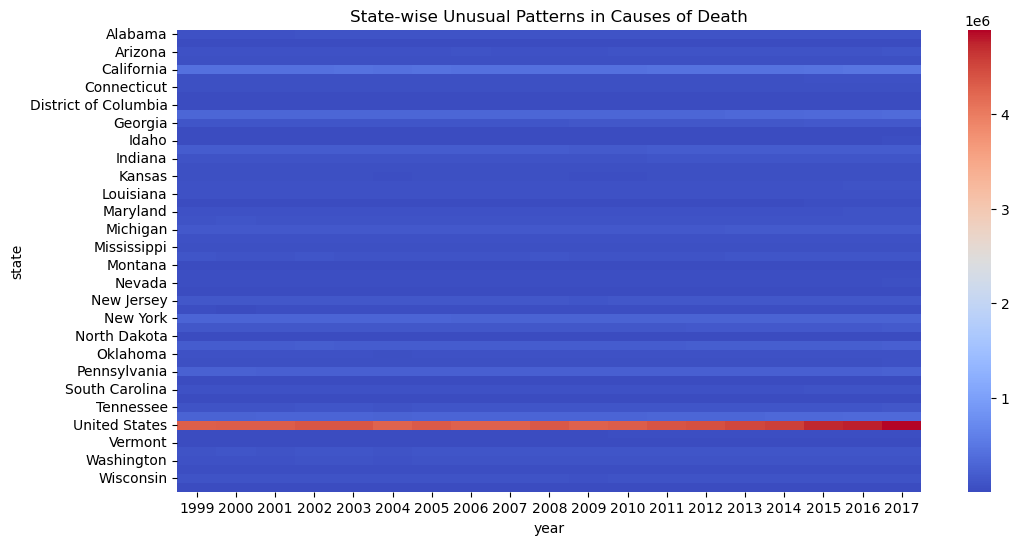

In [18]:
plt.figure(figsize=(12,6))
state_pivot = df.pivot_table(values="deaths", index="state", columns="year", aggfunc="sum")
sns.heatmap(state_pivot, cmap="coolwarm", annot=False)
plt.title("State-wise Unusual Patterns in Causes of Death")
plt.show()


Analyzing unusual patterns in causes of death across states helps detect regional health disparities, guide policy decisions, and allocate public health resources more effectively.

8. Raw Death Counts vs Age-Adjusted Rates

In [19]:
fig = px.bar(df, x="113_cause_name", y=["deaths", "age_adjusted_death_rate"], barmode="group",
             title="Raw Death Counts vs Age-Adjusted Rates")
fig.show()


9. Shifts in Leading Causes of Death Over Time

In [20]:
top_causes_by_year = df.groupby(["year", "113_cause_name"])["deaths"].sum().reset_index()
fig = px.line(top_causes_by_year, x="year", y="deaths", color="113_cause_name",
              title="Changes in Leading Causes of Death Over Time")
fig.show()


10. Interactive Web App Using Flask

a. Panel Dashboard Code

-Supports interactive widgets
-Integrates with Bokeh, Matplotlib, and Plotly
-Runs as a Python script, like Streamlit

In [22]:
pn.extension("plotly")

# Load dataset
df = pd.read_csv("combined_data.csv")
df.columns = df.columns.str.strip().str.lower().str.replace("-", "_").str.replace(" ", "_")

# Dropdown Widget
cause_selector = pn.widgets.Select(name="Cause of Death", options=list(df["113_cause_name"].unique()))

# Function to Update Graph
def plot_graph(cause):
    filtered_df = df[df["113_cause_name"] == cause]
    fig = px.line(filtered_df, x="year", y="deaths", color="state",
                  title=f"Trends in {cause} Deaths by State")
    return pn.pane.Plotly(fig)

# Create Panel App
dashboard = pn.Column(cause_selector, pn.bind(plot_graph, cause_selector))

# Serve the app
dashboard.show()


Launching server at http://localhost:55904
